### Imports

Dataset url: www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torchvision import models
import torchmetrics
import torchinfo
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar

import glob
import uuid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

### Preprocessing

#### Global Parameters

In [2]:
TRAIN_DIR = "../../datasets/brain_tumor_dataset/Training"
VAL_DIR = "../../datasets/brain_tumor_dataset/Testing"

#### Function to create map for encoding labels to right index

In [3]:
# Example path: PATH/glioma_tumor/gg (1).jpg

def encode_labels(root_dir: str) -> dict:
    """

    Args:
        root_dir (str): directory of data

    Returns:
        dict: encoded labels
    """
    filepaths = glob.glob(f"{root_dir}/**/*.jpg")
    extracted_labels = list(map(lambda f: str.split(f, "/")[-2], filepaths))
    unique_labels = list(set(extracted_labels))

    labels = {label: idx for label, idx in zip(unique_labels, range(len(unique_labels)))}
    
    return labels

In [4]:
labels_map = encode_labels(TRAIN_DIR)

In [5]:
labels_map

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'pituitary_tumor': 2, 'no_tumor': 3}

#### Transforms for dataset
img2torch: converts PIL Image to PyTorch tensor \
torch2img: converts PyTorch back to PIL Image

In [6]:
class Transforms:
    def __init__(self):
        self.i2t = T.Compose(
            [
                T.ToTensor(),
                T.Resize((256, 256)),
                T.Lambda(lambda t: 2 * t -1)
            ]
        )
        self.t2i = T.Compose(
            [
                T.Lambda(lambda t: (t + 1) / 2),
                T.Lambda(lambda t: t.permute(1, 2, 0)),
                T.Lambda(lambda t: t * 255),
                T.Lambda(lambda t: t.numpy().astype(np.uint8)),
                T.ToPILImage()
            ]
        )

    def img2torch(self, x: np.array):
        return self.i2t(x)

    def torch2img(self, x: torch.Tensor):
        return self.t2i(x)

#### Visualizing example image

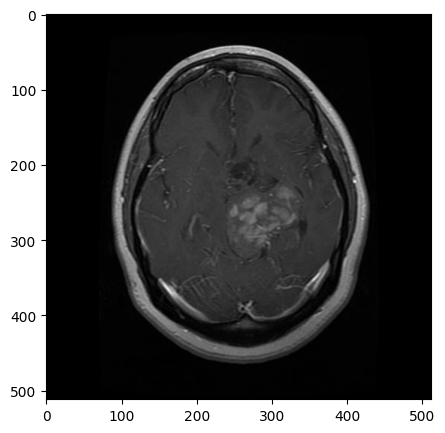

In [7]:
tmp_img = PIL.Image.open(f"{TRAIN_DIR}/glioma_tumor/gg (1).jpg")
plt.figure(figsize=(5, 5))
plt.imshow(tmp_img)

#### Image after transforms

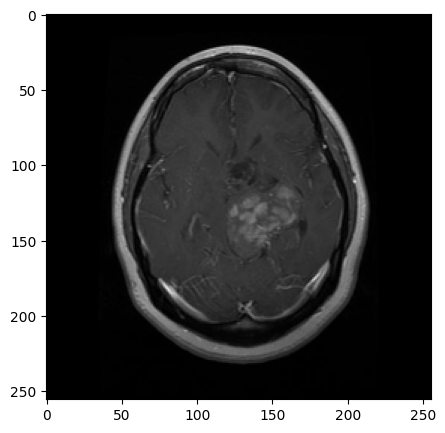

In [8]:
tform = Transforms()
img = tform.img2torch(tmp_img)
img = tform.torch2img(img)
plt.figure(figsize=(5, 5))
plt.imshow(img)

#### Creating Dataset for PyTorch

In [9]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dirs: list, labels_map: dict, transform_func = None):
        """
        Dataset for Brain Tumor Classification

        Args:
            root_dirs (list): directory of dataset
            labels_map (dict): map of labels and their respective indices
            transform_func (callable, optional): specifies function for transforming image. Defaults to None.
        """
        self.root_dirs = root_dirs
        self.labels_map = labels_map
        self.transform_func = transform_func

    def __len__(self):
        return len(self.root_dirs)

    def __getitem__(self, idx):
        # get path to img
        filepath = self.root_dirs[idx]
        # open img with PIL
        image = PIL.Image.open(filepath)
        # get index for label using map
        label_name = str.split(filepath, "/")[-2]
        label = self.labels_map[label_name]

        if self.transform_func:
            image = self.transform_func(image)
        
        return image, label

### Model
I'll be using transfer learning using EfficientNet B4 model pretrained on ImageNet with custom classifier block.

#### Printing model

In [10]:
efficient_net = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.DEFAULT)
efficient_net

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

I'll be using only feature extractor and train classifier from scratch

#### Checking output shape

In [11]:
x = torch.randn(1, 3, 256, 256)
y = efficient_net.features(x)

y.shape

torch.Size([1, 1792, 8, 8])

#### Model

In [12]:
class BrainTumorClassifier(nn.Module):
    def __init__(self, feature_extractor: nn.Module, out_classes: int):
        """

        Args:
            feature_extractor (nn.Module): feature extractor module
            out_classes (int): number of classes
        """
        super().__init__()
        
        # setting feature_extractor to eval so norm layers will work propertly
        self.feature_extractor = feature_extractor.eval()
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1792, 64),
            nn.SiLU(),
            nn.Linear(64, out_classes)
        )

        # freezing weights
        self._freeze_weights(self.feature_extractor)

    def _freeze_weights(self, model: nn.Module):
        for param in model.parameters():
            param.requires_grad_(False)

    def forward(self, x: torch.Tensor):
        # in shape: [batch_size, 3, 256, 256]
        # out shape: [batch_size, 1792, 8, 8]
        features = self.feature_extractor(x)

        # adaptive avg pool [batch_size, 1792, 8, 8] -> [batch_size, 1792, 1, 1]
        features = self.avg_pool(features)

        # out shape: [batch_size, out_classes]
        return self.classifier(features)

#### Checking forward pass

In [13]:
model = BrainTumorClassifier(efficient_net.features, out_classes=4)
x = torch.randn(2, 3, 256, 256)
y = model(x)

y.shape

torch.Size([2, 4])

In [14]:
torchinfo.summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                                  Output Shape              Param #
BrainTumorClassifier                                    [1, 4]                    --
├─Sequential: 1-1                                       [1, 1792, 8, 8]           --
│    └─Conv2dNormActivation: 2-1                        [1, 48, 128, 128]         --
│    │    └─Conv2d: 3-1                                 [1, 48, 128, 128]         (1,296)
│    │    └─BatchNorm2d: 3-2                            [1, 48, 128, 128]         (96)
│    │    └─SiLU: 3-3                                   [1, 48, 128, 128]         --
│    └─Sequential: 2-2                                  [1, 24, 128, 128]         --
│    │    └─MBConv: 3-4                                 [1, 24, 128, 128]         (2,940)
│    │    └─MBConv: 3-5                                 [1, 24, 128, 128]         (1,206)
│    └─Sequential: 2-3                                  [1, 32, 64, 64]           --
│    │    └─MBConv: 3-6                    

### Training

#### Learning Module

In [15]:
class Learner(pl.LightningModule):
    def __init__(self, model: nn.Module, lr: float, l2: float):
        super().__init__()

        self.model = model
        self.lr = lr
        self.l2 = l2

        # metrics to keep track of
        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=4)
        self.f1 = torchmetrics.F1Score("multiclass", num_classes=4)

    def forward(self, x: torch.Tensor):
        return self.model(x)
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.l2)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        
        y_pred = self.model(x)

        loss = F.cross_entropy(y_pred, y)
        acc = self.accuracy(y_pred, y)
        f1 = self.f1(y_pred, y)

        self.log_dict(
            {
                "train/loss": loss,
                "train/acc": acc,
                "train/f1_score": f1
            }
        )

        return {"loss": loss, "progress_bar": {"acc": acc, "f1": f1}}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        
        y_pred = self.model(x)

        loss = F.cross_entropy(y_pred, y)
        acc = self.accuracy(y_pred, y)
        f1 = self.f1(y_pred, y)

        self.log_dict(
            {
                "val/loss": loss,
                "val/acc": acc,
                "val/f1_score": f1
            }
        )

        return {"loss": loss, "progress_bar": {"acc": acc, "f1": f1}}

#### Setting up training

In [16]:
transforms = Transforms()

train_fp = glob.glob(f"{TRAIN_DIR}/**/*.jpg")
val_fp = glob.glob(f"{VAL_DIR}/**/*.jpg")

train_data = BrainTumorDataset(train_fp, labels_map, transform_func=transforms.i2t)
val_data = BrainTumorDataset(val_fp, labels_map, transform_func=transforms.i2t)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True, num_workers=8)
val_loader = DataLoader(val_data, batch_size=256, shuffle=False, num_workers=8)

In [ ]:
progress_bar = TQDMProgressBar()
checkpt = ModelCheckpoint(dirpath="model/", filename=f"model_{str(uuid.uuid1())[:8]}", every_n_epochs=5)

trainer = pl.Trainer(max_epochs=30, callbacks=[progress_bar, checkpt], accelerator="gpu", devices=-1, precision=16)

In [ ]:
learner = Learner(model, lr=3e-4, l2=0.01)

trainer.fit(learner, train_dataloaders=train_loader, val_dataloaders=val_loader)